<div style="background-color: steelblue; padding: 10px; border-radius: 5px;">
    <p style="margin: 10;"></p>
    <h1 style="text-align: center; margin: 0; font-weight: bold; color: white;">
        SWOT Ocean Model Intercomparison Project : EORCA12-ERA5v1 Test Case
    </h1>
    <p style="margin: 10;"></p>
</div>



## 📦**Imports** 

In [191]:
%%time

##################################
#Imports

from datetime import datetime
from datetime import datetime, timedelta
import s3fs
import xarray as xr
import pyinterp
from widetrax import DataPreprocessing as dp
from widetrax import Spectra as sp
import numpy as np
import json
from watermark import watermark
import time
import platform
import tempfile
import geopandas as gpd
import boto3
from boto3.s3.transfer import TransferConfig
from glob import glob

from shapely import geometry

import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import cartopy.feature as cf

CPU times: user 106 μs, sys: 0 ns, total: 106 μs
Wall time: 118 μs


### Model informations

In [192]:
# method = "SCIPY"
# method = "PYINTERP-RBF-LINEAR"
# method = "PYINTERP-RBF-LINEAR-K11"
# method = "PYINTERP-RBF-GAUSSIAN"
method = "PYINTERP-RBF-CUBIC"
method = "PYINTERP-K11"

In [193]:
product = "26" # refers to the absolute wind forcing model

period = "JFM" # or "JAS"
# period = "JAS"
# period = "all"

# region = "A"
region = "B"
# region = "C"

# the root prefix (the model name)
prefix= f"HYCOM50-E0{product}SURF-{method}"

bucket = 'swotce'
prefix

'HYCOM50-E026SURF-PYINTERP-K11'

## 🔍 **Check the S3 Endpoint**  

### To connect to the CNES S3 endpoint, proper credentials are required. However, the same code can be adapted to work with interpolated data from other S3 endpoints as well

In [194]:
session = boto3.Session(profile_name='swotce')
s3client = session.client('s3',endpoint_url='https://s3.datalake.cnes.fr')

In [195]:
# List les objets dans le BUCKET avec le prefix recherché
liste = s3client.list_objects(Bucket=bucket)['Contents']

print(f'Objects key in bucket {bucket} :')
list_files = []
for object in liste[:]:
    list_files.append(object['Key'])
len(list_files)

Objects key in bucket swotce :


1000

In [196]:
# s3_folder =f"swotce/{prefix}"
endpoint_url =  "https://s3.datalake.cnes.fr"

## 🧮 **Required variables**

In [197]:
# Region and period variables

if region == "A":
    lon_min, lon_max, lat_min, lat_max = -70, -60, 32, 42
    
elif region == "B":
    lon_min, lon_max, lat_min, lat_max = -50, -40, 17, 27   

elif region == "C":
    lon_min, lon_max, lat_min, lat_max = -50, -40, 35, 45

area = [lon_min, lat_min, lon_max, lat_max]

if period=="JFM":
    start_date = "01012024" # "DDMMYYYY"
    end_date = "31032024"
elif period=="JAS":
    start_date = "01072024" # "DDMMYYYY"
    end_date ="30092024"

elif period=="all":
    start_date = "01012024" # "DDMMYYYY"
    end_date ="31122024"
    
m1 = datetime.strptime(start_date, "%d%m%Y").month
m2 = datetime.strptime(end_date, "%d%m%Y").month
m1, m2

(1, 3)

## 🔄 **Identify the cycle numbers within the specified time range** 

In [198]:
if period =="JFM":
    file_path = "https://minio.lab.dive.edito.eu/project-meom-ige/cycles_periods.csv" # works only for winter period
else:
    file_path = "time_ranges.csv"  # for summer

matching_cycles = dp.get_matching_cycles(file_path, start_date, end_date)

def formater_numeros_concis(liste_numeros):
  return [str(numero).zfill(3) for numero in liste_numeros]
    
matching_cycles = formater_numeros_concis(matching_cycles)
matching_cycles

['008', '009', '010', '011', '012', '013']

## 📊 **Load datasets and compute Wavenumber spectra**

##### La cellule suivante necessite un credential à cause de la ligne :


In [199]:
%%time
# Load datasets into a dictionary
s3_folder = f"swotce/{prefix}" 
datasets_dict = dp.read_swot_ncfiles_S3subfolders(
    s3_folder,
    matching_cycles,
    endpoint_url,
    area)

Error processing cycle 008: Access Denied
Error processing cycle 009: Access Denied
Error processing cycle 010: Access Denied
Error processing cycle 011: Access Denied
Error processing cycle 012: Access Denied
Error processing cycle 013: Access Denied
CPU times: user 12.5 ms, sys: 1.83 ms, total: 14.3 ms
Wall time: 215 ms


### J'utilise en alternative la fonction définie pour lire les fichiers dans le datalake, après l'avoir customisé

In [200]:
# pour limiter le temps de calcul je cherche et selectionne uniquement les fauchées qui passent par mon domaine et sur la periode voulue

def get_half_orbits_intersect(bbox):
    """Get half orbits that intersect a bounding box.
    Parameters
    ----------
    bbox:
        the bounding box

    Returns
    -------
     gpd.GeoDataFrame:
        A Geopandas dataframe containing intersecting half orbits numbers and geometries
    """
    swath_geometries = gpd.read_file(GEOMETRIES_FILE)

    bbox_polygon = geometry.box(*bbox)

    def _filter_intersect(row, polygon):
        half_orbit_polygon = row.geometry
        return polygon.intersects(half_orbit_polygon)

    select = swath_geometries.apply(_filter_intersect, polygon=bbox_polygon, axis=1)
    return swath_geometries[select]


def swath_search(lsw, lNE, latsw, latNE, GEOMETRIES_FILE):
    
    lon_range = lsw, lNE
    lat_range = latsw, latNE
    bbox = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]
    plot_extent = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]   
    swath_geoms = get_half_orbits_intersect(bbox)
    half_orbits = list(swath_geoms['pass_number'])
    
    return np.transpose(half_orbits)


def fig_box(list_ds):
    """
    cette fonction me permet de faire un scatterplot des fauchées sur ma boîte
    juste pour une verification graphique
    """
    figure, ax = plt.subplots(1, figsize=(8,6), sharex =True, sharey=True, 
                              subplot_kw={"projection": ccrs.PlateCarree()})
    for i in range(len(list_ds)):
        ds = list_ds[i]
        scatter = ax.scatter(ds.longitude, ds.latitude, s = 0.1, c=ds.ssh, vmin=-0.5, vmax = 0.5, cmap='bwr',)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    ax.set_xlim(-85, -30)
    ax.set_ylim(15, 50);
    plt.colorbar(scatter, ax=ax, label='ssh [m]', shrink = 0.6)
    return ax

In [201]:
# Les fauchées qui passe par ma bôite
phase = 'science'
GEOMETRIES_FILE = f'KaRIn_2kms_{phase}_geometries.geojson'
pass_numbers = swath_search(lon_min, lon_max, lat_min, lat_max, GEOMETRIES_FILE)
pass_numbers

array([  5,  18,  33,  46,  74, 102, 199, 227, 255, 268, 283, 296, 311,
       324, 352, 380, 505, 533, 546, 561, 574])

In [202]:
# Cette cellule remplace en partie celle de la fonction "dp.read_swot_ncfiles_S3subfolders"
# Il selectionne les fichiers et uniquement sur la periode d'intérêt

# file listing

list_files = []
for cycle_number in matching_cycles:
    s3_folder = f"{prefix}/cycle_{cycle_number}/" 
    liste = s3client.list_objects(Bucket=bucket,Prefix= s3_folder)['Contents']    # l'accès au buket "swotce"
    for object in liste:
        filename = object['Key']        
        passnumber = int(filename[-15:-12])  # the swot path pass number        
        month = datetime.strptime(filename[-11:-3], "%Y%m%d").month  # the month corresponding to the swath
        
        # passnumber = int(filename[-45:-42])  # the swot path pass number        
        # month = datetime.strptime(filename[-41:-33], "%Y%m%d").month  # the month corresponding to the swath
        
        if (month in range(m1, m2+1)) & (passnumber in pass_numbers): 
            print(filename)
            list_files.append(filename)

print(f"{len(list_files)} are found in the region {region} in {period}")

# ~100 files are found and selected in a 10° x 10° box against ~1500 when pass number and period are not filtered first!

HYCOM50-E026SURF-PYINTERP-K11/cycle_008/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_008_505_20240101.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_008/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_008_533_20240102.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_008/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_008_546_20240102.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_008/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_008_561_20240103.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_008/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_008_574_20240103.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_009/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_009_005_20240104.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_009/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_009_018_20240104.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_009/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_009_033_20240105.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_009/SSH-HYCOM50-E026-INTERP-SWOT-GRID_L3_LR_SSH_009_046_20240105.nc
HYCOM50-E026SURF-PYINTERP-K11/cycle_009/SSH-HYCOM50-E026-INTERP-

In [203]:
# load the listed files

datasets_dict = {}

current_key = 0
for filename in list_files :
    tmp = tempfile.NamedTemporaryFile()
    # tc = TransferConfig(io_chunksize=2621440)   
    with open(tmp.name, 'wb') as f:
        s3client.download_fileobj('swotce', filename, f) # acces to datalake
        ds = xr.open_dataset(tmp.name, engine='netcdf4')
         
        if 'latitude' in ds and 'longitude' in ds:            
            # Handle longitude wrapping
            if lon_min < lon_max:
                ds['longitude'] = xr.where(ds['longitude'] <=180, ds['longitude'], ds['longitude'] - 360) 
                lon_selection = (ds['longitude'] >= lon_min) & (ds['longitude'] <= lon_max)
            else:
                lon_selection = ((ds['longitude'] >= lon_min) & (ds['longitude'] <= 360)) | (ds['longitude'] <= lon_max)
            
            lat_selection = (ds['latitude'] >= lat_min) & (ds['latitude'] <= lat_max)
            # Combine the selection masks
            selection = lat_selection & lon_selection
            
            # Check if selection is valid
            if selection.any():
                # print(f"{filename[61:68]} included.")
                ds = ds.where(selection, drop=True)
                # Add the dataset to the dictionary if it passed all filters
                datasets_dict[current_key] = ds
                current_key +=1
            else :
                ds.close()
                continue
print(current_key, "datasets are listed")

93 datasets are listed


CPU times: user 418 ms, sys: 16.2 ms, total: 434 ms
Wall time: 443 ms


<GeoAxes: >

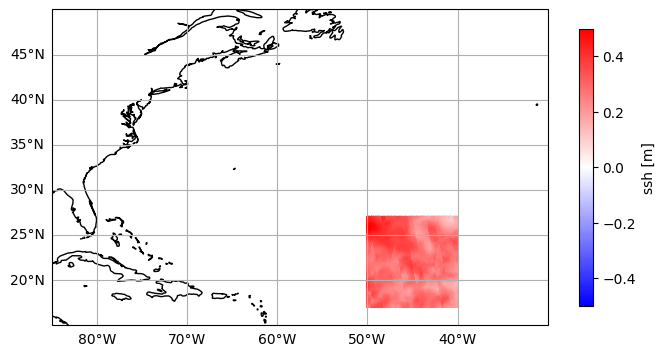

In [204]:
%%time
fig_box(datasets_dict)


In [205]:
%%time
has_converged, filled_datasets = dp.fill_nan(datasets_dict, varname = "ssh")

CPU times: user 2.46 s, sys: 7.55 s, total: 10 s
Wall time: 12.3 s


In [206]:
# ssh_data = filled_datasets[0].ssh.values
# 
# ind = np.argwhere(np.isnan(ssh_data[0,:])==1)
# 69-len(ind)

In [207]:
%%time
segments_dict = sp.retrieve_segments(filled_datasets,FileType = "NetCDF",namevar="ssh")

/work/scratch/env/aguedjh/ceswot-custom/lib/python3.10/site-packages/widetrax/Spectra.py:43: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for col in range(dataset.dims['num_pixels']):


CPU times: user 733 ms, sys: 14 ms, total: 747 ms
Wall time: 828 ms


In [208]:
%%time
psd_dict, freqs_dict = sp.calculate_psd(segments_dict)
# Calculate PSD Mean
psd_mean, freqs_mean = sp.psd_mean_and_freq(psd_dict,freqs_dict)

CPU times: user 1.63 s, sys: 6.87 s, total: 8.5 s
Wall time: 1min 53s


## 💾 **Save Results and Information in JSON File**

In [209]:
# Infos
nom_region = region
model = prefix
freqs_mean = np.array(freqs_mean)
psd_mean = np.array(psd_mean)
todays_Date = datetime.now()
date_creation = todays_Date.isoformat() #ISO 8601 format
packages_versions = watermark(packages="numpy,widetrax,xarray,s3fs,pyinterp,datetime,json,platform,time")
machine_info = {
    "system": platform.system(),
    "node_name": platform.node(),
    "release": platform.release(),
    "version": platform.version(),
    "machine": platform.machine(),
    "processor": platform.processor(),
    "python_version": platform.python_version()
}

# JSON file structure
donnees = {
    "region": nom_region,
    "period" : period,
    "model": model,
    "lon_min": lon_min,
    "lon_max": lon_max,
    "lat_min": lat_min,
    "lat_max": lat_max,
    "start_date": datetime.strptime(start_date, "%d%m%Y").strftime("%Y-%m-%d"),
    "end_date": datetime.strptime(end_date, "%d%m%Y").strftime("%Y-%m-%d"),
    "packages_versions": packages_versions,
    "date_creation": date_creation,
    "login_creator": platform.node(),
    "Frequency": freqs_mean.tolist(),
    "Spectra": psd_mean.tolist(),
    "machine_info": machine_info
}

# Save on JSON file
with open(f"Region_{region}_{period}_{model}.json", "w", encoding="utf-8") as f:
    json.dump(donnees, f, ensure_ascii=False, indent=4)

print("JSON file created")


JSON file created


## 📤 **Export Results to the S3 Endpoint** 

In [20]:
fs = s3fs.S3FileSystem( anon=True, endpoint_url="https://minio.lab.dive.edito.eu", use_ssl=False ) 

In [21]:
json_file = f"Region_{region}_{period}_{model}.json"
json_file

'Region_C_JAS_HYCOM50-E037SURF-SCIPY.json'

In [22]:
upload = False
if upload ==True:
    fs.put(json_file, "project-meom-ige/OMIP/")

In [23]:
# fs.rm('project-meom-ige/OMIP/Region_A_JFM_HYCOM50_AW.json')